In [1]:
# Import useful packages
import uproot
import pandas as pd
import awkward as ak
import numpy as np
import vector
import itertools
import tk as tkinter
import matplotlib
#matplotlib.use('Agg')  # need for not displaying plots when running batch jobs
#matplotlib.use('GTK3Agg')   # need this one if you want plots displayed
from matplotlib import pyplot as plt
from matplotlib import colors
from Plotter import *

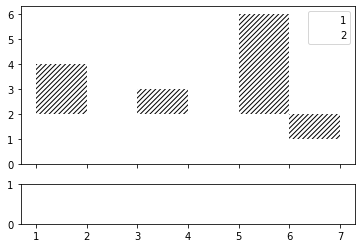

In [2]:
d1 = [1,1,1,3,5,6,4,5,3,1,6,2,3]
d2 = [1,5,1,3,5,5,4,5,5,5,6,2,3]

fig, (ax1, ax2) = plt.subplots(nrows=2,sharex=True,gridspec_kw={'height_ratios': [4, 1]})
n1, b1, _ = ax1.hist(d1,histtype='step',bins=6,range=(1,7),label='1',linewidth=0)
n2, b2, _ = ax1.hist(d2,histtype='step',bins=6,range=(1,7),label='2',linewidth=0)
ax1.bar(x=b1[:-1],height=abs(n1-n2), bottom=np.minimum(n1,n2),width=np.diff(b1),align='edge',hatch='/////',fill=False,linewidth=0,zorder=-1)
#plt.bar(x=b1[:-1],height=abs(n2-n1),width=np.diff(b1),align='edge',linewidth=0,alpha=0.25,zorder=-1)
ax1.legend()

In [3]:
import matplotlib.cm as cm

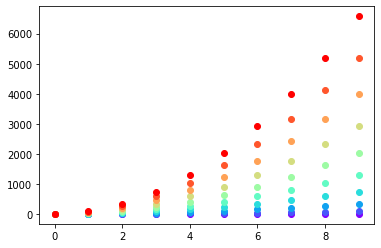

In [11]:

x = np.arange(10)
ys = [i+x+(i*x)**2 for i in range(10)]

colors = cm.rainbow(np.linspace(0, 1, len(ys)))
for y, c in zip(ys, colors):
    plt.scatter(x, y, color=c)

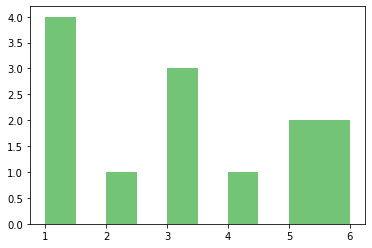

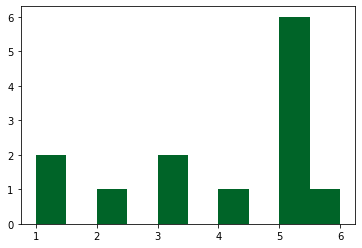

In [47]:
datasets = [d1,d2]
colors = cm.Greens(np.linspace(0.5,0.9,len(datasets)))
for ds, c in zip(datasets,colors):
    plt.figure()
    plt.hist(ds,color=c)

In [17]:
print(n2)
print(n1)
print(np.minimum(n1,n2))

[2. 1. 2. 1. 6. 1.]
[4. 1. 3. 1. 2. 2.]
[2. 1. 2. 1. 2. 1.]


In [2]:
history = np.load('Model_JetPretrain+ttbar/trainHistory_Model_Jet_Pre-train_full.npy',allow_pickle='TRUE').item()
plt.figure(figsize=(8,5))
plt.plot(history['loss'], label='training')
plt.plot(history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-entropy Loss')
plt.legend()
plt.title('JetPretrainer Binary Cross-entropy Loss')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Model_JetPretrain+ttbar/trainHistory_Model_JetPretrain_full.npy'

In [2]:
# ---------- FUNCTION DEFINITIONS ---------- #


# Imports data from 0th file and creates a data frame
# Input: reco_method (i.e.'KLFitter' or 'TRecNet' or 'TRecNet+ttbar') and file name
# Output: data frame
def Create_DF(reco_method,filename,eventnumbers=[]): 
	
    # Open first root file and its trees
    file0 = uproot.open('/mnt/xrootdg/jchishol/mntuples_08_01_22/'+filename)


    # For KLFitter or PseudoTop or Chi2:

    if reco_method=='KLFitter' or reco_method=='PseudoTop' or reco_method=='Chi2':

        tree = file0['nominal'].arrays()
        keys = file0['nominal'].keys()

        # Did an met_met cut for the ML data, so let's match it here too
        #sel = tree['met_met']/1000 >= 20
        #tree = tree[sel]

        # Also split the datafile the same way we did when making the train/test h5 files
        #split_point = int(np.round(len(tree['eventNumber'])*0.85))
        #tree = tree[split_point:]

        # Only take events with the same event numbers as the test data
        sel = np.isin(tree['eventNumber'],eventnumbers)
        tree = tree[sel]

        # Initialize list of variable names
        names = []
        model_name = 'PseudoTop_Reco_' if reco_method=='PseudoTop' else 'TtresChi2_' if reco_method=='Chi2' else 'klfitter_bestPerm_'


        # Add reco variables to be plotted
        for par in [top_had,top_lep,top_antitop]:      # For each particle

            # Get all the possible names for this particle
            alt_par_names = list(par.alt_names)
            alt_par_names.append(par.name)

            for var in par.variables:                  # For each variable of that particle

                # Reset
                found_reco=False
                found_truth=False

                # Get all the possible names for this variable
                alt_var_names = list(var.alt_names)
                alt_var_names.append(var.name)

                for (par_name,var_name) in list(itertools.product(alt_par_names,alt_var_names)):
                    if model_name+par_name+'_'+var_name in keys:
                        names.append(['reco_'+par.name+'_'+var.name,model_name+par_name+'_'+var_name])
                        found_reco=True
                        if reco_method=='Chi2' and var.name=='eta' and par.name=='ttbar': print(model_name+par_name+'_'+var_name)
                    if model_name+var_name in keys: # (particularly, chi_tt)
                        names.append(['reco_'+par.name+'_'+var.name,model_name+var_name])
                        found_reco=True
                        if reco_method=='Chi2' and var.name=='eta' and par.name=='ttbar': print(model_name+var_name)
                    if 'MC_'+par_name+'_afterFSR_'+var_name in keys:
                        names.append(['truth_'+par.name+'_'+var.name,'MC_'+par_name+'_afterFSR_'+var_name])
                        found_truth=True
                        if reco_method=='Chi2' and var.name=='eta' and par.name=='ttbar': print('MC_'+par_name+'_afterFSR_'+var_name)
                    if 'MC_'+var_name in keys:  # (particularly, chi_tt)
                        names.append(['truth_'+par.name+'_'+var.name,'MC_'+var_name])
                        found_truth = True
                        if reco_method=='Chi2' and var.name=='eta' and par.name=='ttbar': print('MC_'+var_name)
                    # if 'MC_'+par_name+var_name in keys: # (in particular, for Pout)
                    #     df['truth_'+par.name+'_'+var.name] = ak.to_pandas(tree['MC_'+par_name+var_name])    # Append the true values
                    #     found_truth=True

                    # Stop looking for the correct names once we find them
                    if found_reco and found_truth:
                        break

        # Create dataframe!
        df = ak.to_pandas({new_name:tree[old_name] for (new_name,old_name) in names})

        df['eventNumber'] = tree['eventNumber']

        # Bring in Chi2 for ... Chi2 lol
        if reco_method=='Chi2':
            df['chi2'] = tree['TtresChi2_Chi2']

        elif reco_method=='KLFitter':

            # Note: some events did not have a logLikelihood calculated -- we will need to pad these events to make sure nothing gets shifted weird, and then cut them
            df['logLikelihood'] = ak.flatten(ak.fill_none(ak.pad_none(tree['klfitter_logLikelihood'],1),np.nan))


        # Include number of jets, so we can look at how they might compare
        df['jet_n'] = tree['jet_n']

        # Drop bad klfitter events
        df.replace([np.inf,-np.inf],np.nan,inplace=True)
        df.dropna(inplace=True)



    # For TRecNet models:

    else:
        print('made it here')
        tree_truth0 = file0['parton'].arrays()
        tree_reco0 = file0['reco'].arrays()
        keys = file0['parton'].keys()   # Should be same for reco

        print('making frames')
        truth_df = ak.to_pandas({'truth_'+key:tree_truth0[key] for key in keys})
        reco_df = ak.to_pandas({'reco_'+key:tree_reco0[key] for key in keys})
        df = pd.concat([truth_df,reco_df], axis=1)

        df['eventNumber'] = tree_truth0['eventNumber']

    # Close root file
    file0.close()

    print('Appended file '+filename+' to '+reco_method+' dataframe.')	

    # Return main data frame
    return df


# Appends data from the rest of the files to the existing data frame
# Note: currently used for KLFitter, not ML (only have one result file from the testing.ipynb)
# Input: data frame and name of file to be appended
# Output: data frame
def Append_Data(df,reco_method,filename,eventnumbers=[]):

    # Get the data from the new file
    df_addon = Create_DF(reco_method,filename,eventnumbers)
        
    # Append data to the main data frame
    df = pd.concat([df,df_addon],axis=0,ignore_index=True)

    #print('Appended file '+filename)

    return df


# KLFitter is missing some variables I'd like to compare

def Append_Calculations(df,reco):

    for level in ['truth','reco']:

        # ttbar deta
        th_vec = vector.arr({"pt": df[level+'_th_pt'], "phi": df[level+'_th_phi'], "eta": df[level+'_th_eta'],"mass": df[level+'_th_m']})
        tl_vec = vector.arr({"pt": df[level+'_tl_pt'], "phi": df[level+'_tl_phi'], "eta": df[level+'_tl_eta'],"mass": df[level+'_tl_m']}) 
        df[level+'_ttbar_deta'] = abs(th_vec.deltaeta(tl_vec))

        if reco=='KLFitter' or reco=='PseudoTop':

            # dphi
            df[level+'_ttbar_dphi'] = abs(th_vec.deltaphi(tl_vec))

            # ttbar Ht
            df[level+'_ttbar_Ht'] = df[level+'_th_pt']+df[level+'_tl_pt']

            # ttbar yboost and ystar
            df[level+'_ttbar_yboost'] = 0.5*(df[level+'_th_y']+df[level+'_tl_y'])
            #df[level+'_ttbar_ystar'] = 0.5*(df[level+'_th_y']-df[level+'_tl_y'])


    return df






# I THINK THIS IS NOW ALL DONE IN THE PREP STAGE
# CONFUSED BECUZ PRETTY SURE I DID BUT IT'S NOT REALLY THERE
# NVM CUTS ARE DONE BUT NOT SCALING NEED TO DO THAT NOW

# Drops unmatched data, converts units, and calculates resolution
# Note: currently used for KLFitter, not ML
# Input: data frame
# Output: data frame
def Edit_Data(df):

    # Cut unwanted events
    #indexNames = df[df['reco_isMatched'] == 0 ].index   # Want truth events that are detected in reco
    #df.drop(indexNames,inplace=True)
    #indexNames = df[df['truth_isDummy'] == 1 ].index    # Want reco events that match to an actual truth event
    #df.drop(indexNames,inplace=True)  
    #df.dropna(subset=['truth_th_y'],inplace=True)     # Don't want NaN events
    #df.dropna(subset=['truth_tl_y'],inplace=True)     # Don't want NaN events

    for par in [top_had,top_lep,top_antitop]:           # For each particle
    	for var in par.variables:    # For each variable of that particle
        
            # Convert from MeV to GeV for some truth values
            if var.name in ['pt','m','E','pout','Ht'] and 'truth_'+par.name+'_'+var.name in df.keys():  
                df['truth_'+par.name+'_'+var.name] = df['truth_'+par.name+'_'+var.name]/1000

    return df



def Check(df,reco):

    print('Checking ...',reco)

    for level in ['truth','reco']:
    
        # Check pt, m, and E are not negative, and phi is within (-pi, pi)
        for par in ['th', 'tl', 'ttbar']:
            for var in ['pt','m','E']:
                if min(df[level+'_'+par+'_'+var]) < 0:
                    print('WARNING: '+reco+' has '+par+'_'+var+' < 0 at the '+level+' level!')
                    print(df[df[level+'_'+par+'_'+var]<0])
            if max(df[level+'_'+par+'_phi']) > np.pi:
                print('WARNING: '+reco+' has '+par+'_phi'+' > pi at the '+level+' level!')  
                print(df[df[level+'_'+par+'_phi'] > np.pi][level+'_'+par+'_phi'])
                print(df[df[level+'_'+par+'_phi'] > np.pi]['eventNumber'])
            if min(df[level+'_'+par+'_phi']) < -np.pi:
                print('WARNING: '+reco+' has '+par+'_phi'+' < -pi at the '+level+' level!')    
                print(df[df[level+'_'+par+'_phi'] < -np.pi])    

        # Check Ht, chi, dphi, deta are all above zero
        for var in ['Ht','chi','dphi','deta']:
            if min(df[level+'_ttbar_'+var]) < 0:
                print('WARNING: '+reco+' has ttbar_'+var+' < 0 at the '+level+' level!')  
                print(df[df[level+'_ttbar_'+var] < 0])       

        # Check ttbar_dphi < pi
        if max(df[level+'_ttbar_dphi']) > np.pi:
            print('WARNING: '+reco+' has ttbar_dphi > pi at the '+level+' level!')  
            print(df[df[level+'_ttbar_dphi'] > np.pi])

        

            
    


# ------------- MAIN CODE ------------- #




# Define all the variables and their ranges we want
scale = '[GeV]'
pt = Variable('pt', 'p_T', np.arange(0,550,50), unit=scale)
eta = Variable('eta', '\eta', np.arange(-6,7.5,1.5))
y = Variable('y', 'y', np.arange(-2.5,3,0.5))
phi = Variable('phi', '\phi', np.arange(-3,3.75,0.75))
m_t = Variable('m','m', np.arange(100,260,20),unit=scale)
E_t = Variable('E','E', np.arange(100,1600,150),unit=scale)
#pout_t = Variable('pout','p_{out}',range(-275,325,50), unit=scale,alt_names=['Pout'])
m_tt = Variable('m','m', np.arange(200,1700,150),unit=scale)
E_tt = Variable('E','E', np.arange(200,2700,250),unit=scale)
dphi_tt = Variable('dphi','|\Delta\phi|', np.arange(0,3.6,0.45),alt_names=['deltaPhi'])
deta_tt = Variable('deta','|\Delta\eta|', np.arange(0,10,1),alt_names=['deltaEta'])
Ht_tt = Variable('Ht','H_T',np.arange(0,1200,120),unit=scale,alt_names=['HT'])
yboost_tt = Variable('yboost','y_{boost}',np.arange(-3,3.75,0.75),alt_names=['y_boost'])
#ystar_tt = Variable('ystar','y_{star}',np.arange(-2.5,3,0.5),alt_names=['y_star'])
chi_tt = Variable('chi','\chi',np.arange(0,25,2.5),alt_names=['chi_tt'])

# Define the particles we want
top_had = Particle('th','t,had',[pt,eta,y,phi,m_t,E_t],alt_names=['thad','topHad','top_had'])
top_lep = Particle('tl','t,lep',[pt,eta,y,phi,m_t,E_t],alt_names=['tlep','topLep','top_lep'])
top_antitop = Particle('ttbar','t\overline{t}',[pt,eta,y,phi,m_tt,E_tt,dphi_tt,deta_tt,Ht_tt,yboost_tt,chi_tt])

In [3]:
#for datatype in ['parton_ejets','parton_mjets']:
for datatype in ['parton_e+mjets']:   # Should be able to remove this now


    # Create the ML dataframes
    TRecNet_df = Create_DF('TRecNet','Model_Custom_full_Results.root')
    TRecNet_ttbar_df = Create_DF('TRecNet+ttbar','Model_Custom+ttbar_full_Results.root')
    TRecNet_jetPretrain_df = Create_DF('TRecNet+ttbar','Model_JetPretrain+ttbar_full_Results.root')
    
    # Get the list of events that was used in the test data
    eventnumbers = np.array(TRecNet_df['eventNumber'])

    # Create the data frames and dataset objects for KLFitter, PseudoTop, and Chi2
    #KLF_df = Create_DF('KLFitter','mc16a/mntuple_ljets_1_jetMatch04.root',eventnumbers)
    #PT_df = Create_DF('PseudoTop','mc16a/mntuple_ljets_1_jetMatch04.root',eventnumbers)
    Chi2_df = Create_DF('Chi2','mc16a/mntuple_ljets_1_jetMatch04.root',eventnumbers)

    for n in range(2,12):  # Use the same files as were used for testing!
        #KLF_df = Append_Data(KLF_df,'KLFitter','mc16a/mntuple_ljets_'+str(n)+'_jetMatch04.root',eventnumbers)
        #PT_df = Append_Data(PT_df,'PseudoTop','mc16a/mntuple_ljets_'+str(n)+'_jetMatch04.root',eventnumbers)
        Chi2_df = Append_Data(Chi2_df,'Chi2','mc16a/mntuple_ljets_'+str(n)+'_jetMatch04.root',eventnumbers)

    for n in range(1,35):  # Use the same files as were used for testing!
        if n==14 or n==15: continue
        #KLF_df = Append_Data(KLF_df,'KLFitter','mc16d/mntuple_ljets_'+str(n)+'_jetMatch04.root',eventnumbers)
        #PT_df = Append_Data(PT_df,'PseudoTop','mc16d/mntuple_ljets_'+str(n)+'_jetMatch04.root',eventnumbers)
        Chi2_df = Append_Data(Chi2_df,'Chi2','mc16d/mntuple_ljets_'+str(n)+'_jetMatch04.root',eventnumbers)

    for n in range(1,36):  # Use the same files as were used for testing!
        #KLF_df = Append_Data(KLF_df,'KLFitter','mc16e/mntuple_ljets_'+str(n)+'_jetMatch04.root',eventnumbers)
        #PT_df = Append_Data(PT_df,'PseudoTop','mc16e/mntuple_ljets_'+str(n)+'_jetMatch04.root',eventnumbers)
        Chi2_df = Append_Data(Chi2_df,'Chi2','mc16e/mntuple_ljets_'+str(n)+'_jetMatch04.root',eventnumbers)


    # print('Checking event numbers:')
    # print(set(KLF_df['eventNumber']).issubset(TRecNet_df['eventNumber']))
    # print('KLF length: ',len(KLF_df['eventNumber']))
    # print('TRecNet length: ',len(TRecNet_df['eventNumber']))
    # total_test_events = len(TRecNet_df['eventNumber'])




    # Append calculations of some variables
    # TRecNet_df = Append_Calculations(TRecNet_df,'TRecNet')
    # TRecNet_ttbar_df = Append_Calculations(TRecNet_ttbar_df,'TRecNet+ttbar')
    # TRecNet_jetPretrain_df = Append_Calculations(TRecNet_jetPretrain_df,'TRecNet_JetPretrain+ttbar')
    # KLF_df = Append_Calculations(KLF_df,'KLFitter')
    # PT_df = Append_Calculations(PT_df,'PseudoTop')
    # #Chi2_df = Append_Calculations(Chi2_df,'Chi2')

    # # Edit data as necessary
    # KLF_df = Edit_Data(KLF_df)
    # PT_df = Edit_Data(PT_df)
    Chi2_df = Edit_Data(Chi2_df)


made it here
making frames
Appended file Model_Custom_full_Results.root to TRecNet dataframe.
made it here
making frames
Appended file Model_Custom+ttbar_full_Results.root to TRecNet+ttbar dataframe.
made it here
making frames
Appended file Model_JetPretrain+ttbar_full_Results.root to TRecNet+ttbar dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16a/mntuple_ljets_1_jetMatch04.root to Chi2 dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16a/mntuple_ljets_2_jetMatch04.root to Chi2 dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16a/mntuple_ljets_3_jetMatch04.root to Chi2 dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16a/mntuple_ljets_4_jetMatch04.root to Chi2 dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16a/mntuple_ljets_5_jetMatch04.root to Chi2 dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16a/mntuple_ljets_6_jetMatch04.root to Chi2 dataframe.
TtresChi2_t

TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16e/mntuple_ljets_28_jetMatch04.root to Chi2 dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16e/mntuple_ljets_29_jetMatch04.root to Chi2 dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16e/mntuple_ljets_30_jetMatch04.root to Chi2 dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16e/mntuple_ljets_31_jetMatch04.root to Chi2 dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16e/mntuple_ljets_32_jetMatch04.root to Chi2 dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16e/mntuple_ljets_33_jetMatch04.root to Chi2 dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16e/mntuple_ljets_34_jetMatch04.root to Chi2 dataframe.
TtresChi2_ttbar_eta
MC_ttbar_afterFSR_eta
Appended file mc16e/mntuple_ljets_35_jetMatch04.root to Chi2 dataframe.


In [5]:
# Calculate mean and standard deviation of the resolution
Chi2_df['res_ttbar_eta'] = Chi2_df['reco_ttbar_eta'] - Chi2_df['truth_ttbar_eta']
res_mean = round(Chi2_df['res_ttbar_eta'].mean(),sigfigs=2)
res_std = round(Chi2_df['res_ttbar_eta'].std(),sigfigs=2)
print(Chi2_df[['reco_ttbar_eta','truth_ttbar_eta','res_ttbar_eta']])
print('Mean: ',res_mean)
print('Stdev: ',res_std)

         reco_ttbar_eta  truth_ttbar_eta  res_ttbar_eta
0              1.984922         1.997442      -0.012520
1             -2.026003        -1.735226      -0.290778
2             -2.045599         0.171953      -2.217552
3             -1.026348        -1.466989       0.440641
4             -3.387079        -3.363608      -0.023470
...                 ...              ...            ...
3942022        2.666966         1.957256       0.709710
3942023       -5.421611        -3.985642      -1.435970
3942024        1.923310         1.710842       0.212468
3942025        2.568694         2.721575      -0.152881
3942026        1.498330        -0.781772       2.280102

[3942027 rows x 3 columns]
Mean:  -76000.0
Stdev:  110000000.0


In [16]:
Chi2_df[Chi2_df['res_ttbar_eta']>50]

,truth_th_pt,truth_th_eta,truth_th_y,truth_th_phi,truth_th_m,reco_th_m,truth_th_E,truth_tl_pt,truth_tl_eta,truth_tl_y,...,reco_ttbar_m,truth_ttbar_m,reco_ttbar_E,truth_ttbar_E,truth_ttbar_yboost,truth_ttbar_chi,eventNumber,chi2,jet_n,res_ttbar_eta
1794230,159.022094,0.955952,0.692628,-2.574789,173.302906,178.805481,293.916125,170.318719,1.574747,1.25478,...,536.212952,497.258781,877.923828,756.88,0.973704,1.754445,515191597,3.010396,4,1.000000e+11


In [12]:
Chi2_df[Chi2_df['res_ttbar_eta']<-100]

,truth_th_pt,truth_th_eta,truth_th_y,truth_th_phi,truth_th_m,reco_th_m,truth_th_E,truth_tl_pt,truth_tl_eta,truth_tl_y,...,reco_ttbar_m,truth_ttbar_m,reco_ttbar_E,truth_ttbar_E,truth_ttbar_yboost,truth_ttbar_chi,eventNumber,chi2,jet_n,res_ttbar_eta
42948,171.776172,-2.516752,-2.199519,2.367575,163.695516,172.162003,1083.378500,172.835594,-1.249360,-0.971170,...,518.361084,575.638187,1558.187012,1452.607625,-1.585344,3.415584,340581469,5.325052,4,-1.000000e+11
595826,274.661187,-1.316670,-1.172565,0.090247,174.963125,156.132309,576.382562,309.864906,-0.469665,-0.411673,...,699.574463,731.008125,963.926025,963.521687,-0.792119,2.140185,22371649,2.908686,4,-1.000000e+11
658168,58.678738,-3.323437,-2.223938,-1.420845,168.100234,158.595505,832.535938,65.478684,-0.093832,-0.034045,...,436.091827,595.884750,1020.486816,1013.219938,-1.128991,8.934261,52035661,1.745149,4,-1.000000e+11
721176,93.660383,-2.205568,-1.504880,-1.510621,172.306062,173.522263,463.389344,99.883539,-1.200605,-0.698122,...,459.332245,425.776594,645.549683,713.532125,-1.101501,2.240631,36283932,1.463184,4,-1.000000e+11


In [39]:
bad_df = pd.concat([Chi2_df[Chi2_df['res_ttbar_eta']>50],Chi2_df[Chi2_df['res_ttbar_eta']<-50]],axis=0,ignore_index=True)

In [40]:
bad_df[['eventNumber','truth_ttbar_eta','reco_ttbar_eta','res_ttbar_eta','truth_ttbar_pt','reco_ttbar_pt','truth_ttbar_m','reco_ttbar_m','truth_ttbar_phi','reco_ttbar_phi','truth_ttbar_E','reco_ttbar_E','truth_ttbar_y','reco_ttbar_y','chi2']]

,eventNumber,truth_ttbar_eta,reco_ttbar_eta,res_ttbar_eta,truth_ttbar_pt,reco_ttbar_pt,truth_ttbar_m,reco_ttbar_m,truth_ttbar_phi,reco_ttbar_phi,truth_ttbar_E,reco_ttbar_E,truth_ttbar_y,reco_ttbar_y,chi2
0,515191597,3.587111,1.000000e+11,1.000000e+11,31.562967,2.386466e-06,497.258781,536.212952,1.856967,0.550429,756.880000,877.923828,0.979269,1.076252,3.010396
1,340581469,-7.598602,-1.000000e+11,-1.000000e+11,1.336754,9.441785e-07,575.638187,518.361084,-0.328117,-0.854616,1452.607625,1558.187012,-1.576984,-1.764862,5.325052
2,22371649,-3.482955,-1.000000e+11,-1.000000e+11,38.524875,2.605044e-06,731.008125,699.574463,-2.605441,1.935929,963.521687,963.926025,-0.775699,-0.844059,2.908686
3,52035661,-5.282712,-1.000000e+11,-1.000000e+11,8.323400,1.758573e-06,595.884750,436.091827,2.402511,0.704350,1013.219938,1020.486816,-1.123374,-1.494188,1.745149
4,36283932,-3.212536,-1.000000e+11,-1.000000e+11,46.022781,1.146667e-06,425.776594,459.332245,-2.975240,-0.719502,713.532125,645.549683,-1.098211,-0.872514,1.463184
